In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

# Load Titanic dataset
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
# Drop rows where target is missing
df = df.dropna(subset=['survived'])

# Select relevant features for logistic regression
features = [
    'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
    'fare', 'embarked', 'class', 'who', 'adult_male', 'deck',
    'embark_town', 'alone'
]

df = df[features]

# Impute missing values
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['embark_town'] = df['embark_town'].fillna(df['embark_town'].mode()[0])
# df['deck'] = df['deck'].fillna('Unknown')  # Treat missing deck as 'Unknown'

# Convert categorical variables to 'category' dtype
categorical_cols = ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [4]:
df['deck'].value_counts()

deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64

In [5]:
df['deck'].shape

(891,)

In [6]:
df['deck'].isna().sum()

688

In [7]:
df = df.drop('deck', axis=1)

In [8]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Define the logistic regression formula
formula = 'survived ~ C(pclass) + C(sex) + age + sibsp + parch + fare + C(embarked) + C(alone)'

# Fit the GLM model
model = smf.glm(
    formula=formula
    , data=df
    , family=sm.families.Binomial()
).fit()

# Print model summary
print(model.summary2())

                Results: Generalized linear model
Model:                GLM              AIC:            799.6967  
Link Function:        Logit            BIC:            -5199.5664
Dependent Variable:   survived         Log-Likelihood: -388.85   
Date:                 2025-04-29 16:43 LL-Null:        -593.33   
No. Observations:     891              Deviance:       777.70    
Df Model:             10               Pearson chi2:   910.      
Df Residuals:         880              Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         4.5166   0.5125   8.8128 0.0000  3.5121  5.5211
C(pclass)[T.2]   -0.9250   0.2983  -3.1015 0.0019 -1.5096 -0.3405
C(pclass)[T.3]   -2.0774   0.2998  -6.9304 0.0000 -2.6649 -1.4899
C(sex)[T.male]   -2.6406  

In [9]:
# Calculate odds ratios and 95% CI
params = model.params
conf = model.conf_int()
odds_ratios = pd.DataFrame(
    {'OR': params.apply(lambda x: round(np.exp(x), 2))
     , '2.5%': conf[0].apply(lambda x: round(np.exp(x), 2))
     , '97.5%': conf[1].apply(lambda x: round(np.exp(x), 2))
})
print(odds_ratios)

                     OR   2.5%   97.5%
Intercept         91.52  33.52  249.90
C(pclass)[T.2]     0.40   0.22    0.71
C(pclass)[T.3]     0.13   0.07    0.23
C(sex)[T.male]     0.07   0.05    0.11
C(embarked)[T.Q]   1.06   0.50    2.26
C(embarked)[T.S]   0.72   0.44    1.15
C(alone)[T.True]   0.47   0.27    0.82
age                0.96   0.95    0.98
sibsp              0.59   0.44    0.78
parch              0.78   0.60    1.02
fare               1.00   1.00    1.01


In [10]:
import numpy as np

# Predict survival probabilities
df['predicted_prob'] = model.predict(df)

# Convert probabilities to binary class predictions with threshold 0.5
df['predicted_class'] = (df['predicted_prob'] >= 0.5).astype(int)


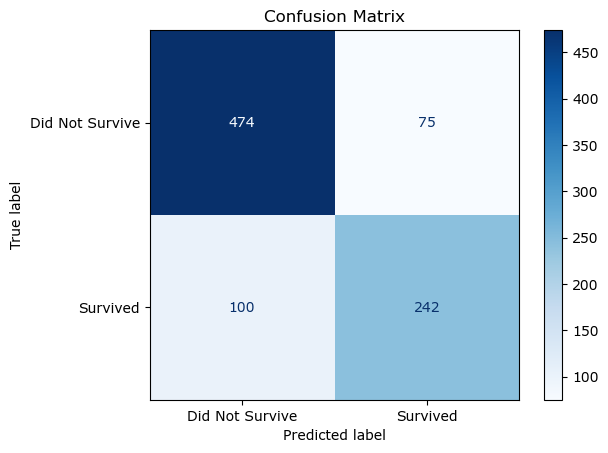

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Actual and predicted values
y_true = df['survived']
y_pred = df['predicted_class']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
    , display_labels=[
        'Did Not Survive', 'Survived'])

# Plot it
import matplotlib.pyplot as plt
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()